In [5]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_validate
import tqdm
import random

In [6]:
from common import get_data, get_freq_data, signal_cyclic_shift, get_ref_time, generate_multi_signal, get_argmin_distr

In [7]:
X_origin, y_origin = get_data(data_path='./data/shashlik_61_pulses.txt')

mean_argmin =  int(np.argmin(X_origin, axis=1).mean())

In [8]:
ARGMIN_DISTR = get_argmin_distr('./data/shashlik_61_pulses.txt')

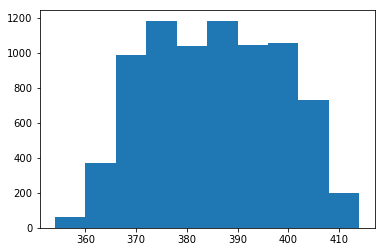

In [9]:
plt.hist(ARGMIN_DISTR)
plt.show()

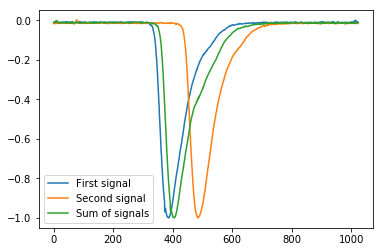

{'first_impulse': array([-0.00840282, -0.01019885, -0.01150096, ..., -0.00904426,
        -0.01021809, -0.01026299]),
 'multi_impulse': array([-0.00988757, -0.01165197, -0.01301528, ..., -0.01037353,
        -0.01159107, -0.01167061]),
 'multi_ref_time': 185,
 'second_impulse': array([ -6.38057274e-04,  -5.68565887e-03,  -1.38982772e-02, ...,
         -6.31739875e-06,  -1.88890223e-03,   0.00000000e+00])}

In [10]:
generate_multi_signal(X_origin, y_origin, 100, 0.1, to_plot=True, argmin_distr=ARGMIN_DISTR)

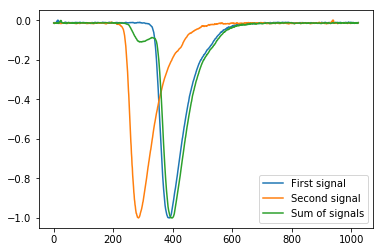

{'first_impulse': array([-0.01296622, -0.01477829, -0.01526493, ..., -0.01420842,
        -0.01507924, -0.01222347]),
 'multi_impulse': array([-0.01412457, -0.01584043, -0.01642248, ..., -0.0153071 ,
        -0.01608439, -0.01338072]),
 'multi_ref_time': 176,
 'second_impulse': array([-0.01645236, -0.01479362, -0.01503793, ..., -0.01543654,
        -0.01553298, -0.0161759 ])}

In [11]:
generate_multi_signal(X_origin, y_origin, -100, 0.1, to_plot=True, argmin_distr=ARGMIN_DISTR)

In [12]:
from sklearn.utils import shuffle

def prepare_data(X_origin, y_origin, tau_range, alpha_range, data_size=1000, to_print=False):    
    X = []
    y = []
    alpha_values = []
    tau_values = []
    for i in range(data_size):
        alpha = random.choice(alpha_range)
        tau = random.choice(tau_range)
        signal = generate_multi_signal(X_origin, y_origin, tau, alpha, argmin_distr=ARGMIN_DISTR)
        
        
        X.append(signal['multi_impulse'])
        y.append(signal['multi_ref_time']) 
        
        alpha_values.append(alpha)
        tau_values.append(tau)
   
    X = np.array(X)
    y = np.array(y)
    
    if to_print:
        print("X shape:", X.shape)
        print("y shape:", y.shape)
    
    X, y = shuffle(X, y)

#     plt.scatter(alpha_values, tau_values)
#     plt.show()
    
    return X, y

In [13]:
# alpha_range = np.array([np.around(10**i, decimals=4) for i in np.arange(0, 3.1, 0.01)])

# alpha_range = [10]
# tau_range = [0]
alpha_range = np.array([np.around(10**i, decimals=4) for i in np.arange(-3, 3.1, 0.1)])
tau_range = np.arange(-25, 25, 1)

In [14]:
plt.hist(np.log10(alpha_range))

(array([ 6.,  7.,  5.,  6.,  6.,  6.,  7.,  6.,  6.,  6.]),
 array([-3. , -2.4, -1.8, -1.2, -0.6,  0. ,  0.6,  1.2,  1.8,  2.4,  3. ]),
 <a list of 10 Patch objects>)

In [15]:
X, y = prepare_data(X_origin, y_origin, tau_range, alpha_range, data_size=5000, to_print=True) 

X shape: (5000, 1024)
y shape: (5000,)


In [16]:
# X = get_freq_data(X, freq=15)

In [17]:
X.shape

(5000, 1024)

In [18]:
from sklearn.preprocessing import normalize

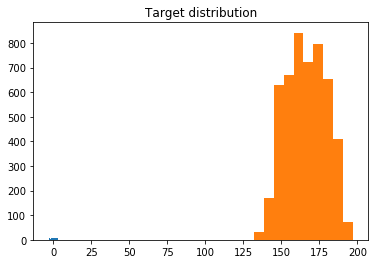

In [19]:
plt.title("Target distribution")
plt.hist(y)
plt.show()

In [20]:
# idxs = []
# for i in range(len(y)):
#     if y[i] < 100:
#         idxs.append(i)
        
# i = 1
# plt.title("Multiple impulse")
# plt.plot(X[idxs[i]])
# print("Ref time:", y[idxs[i]])

In [21]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import HuberRegressor
from sklearn import linear_model
from sklearn import tree
from sklearn import svm
from sklearn.linear_model import PassiveAggressiveRegressor
import xgboost as xgb
from catboost import CatBoostRegressor

ModuleNotFoundError: No module named 'xgboost'

In [25]:
def print_scores():
    for model in models.values():    
        model_name = type(model).__name__
        print("Regressor:", model_name)
    #         stregr = StackingRegressor(regressors=models, meta_regressor=model)
        scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
        scores = cross_validate(model, X, y, scoring=scoring, cv=5)

        r2_score_mean = scores['test_r2'].mean()
        r2_score_std = scores['test_r2'].std()
        mse_score_mean = -scores['test_neg_mean_squared_error'].mean()
        mse_score_std = scores['test_neg_mean_squared_error'].std()
        mae_score_mean = -scores['test_neg_mean_absolute_error'].mean()
        mae_score_std = scores['test_neg_mean_absolute_error'].std()
        rmse_score_mean = np.sqrt(-scores['test_neg_mean_squared_error']).mean()
        rmse_score_std = np.sqrt(-scores['test_neg_mean_squared_error']).std()

        cur_scores = [(r2_score_mean, r2_score_std), (mse_score_mean, mse_score_std),\
                          (mae_score_mean, mae_score_std), (rmse_score_mean, rmse_score_std)]
    #         print('!!!!!!!!')
    #         print("TEST")
    #         print(models_scores[type(models[0]).__name__]['r2'])
    #         print('!!!!!!!!')
        print("95% confidence interval:")
        for i, metric in enumerate(['r2', 'mse', 'mae', 'rmse'], 0):
    #         models_scores[model_name][metric].append(cur_scores[i])
            print(metric, "score: %0.5f (+/- %0.5f)" % (cur_scores[i][0], 2*cur_scores[i][1]))
        print('----------------------------------')
    print('____________________________________________________________')
    print()

In [26]:
import warnings
warnings.filterwarnings("ignore")

In [27]:
def get_models():
    huber_reg = HuberRegressor(epsilon= 1.242, alpha= 0.01)
    ridge_reg = linear_model.Ridge(solver='lsqr', max_iter=4000, alpha=  0.513)
    lasso_reg = linear_model.Lasso(max_iter=4400, alpha= 0.00849, normalize=False)
    dt_reg = tree.DecisionTreeRegressor(min_samples_split=9, min_samples_leaf=9, min_weight_fraction_leaf=0.018, 
                                                                                                 max_features='auto')

    pa_reg = PassiveAggressiveRegressor(C=0.44, max_iter=2800, tol=2.4e-5)
    xgb_reg = xgb.XGBRegressor(objective="reg:linear", alpha= 0.01, booster='gbtree', eta= 0.323, gamma=0.189, 
                               reg_lambda=0.48, max_depth=6, verbosity=0)
    return {'huber': huber_reg, 'ridge': ridge_reg, 'lasso': lasso_reg, 'dt': dt_reg, 'pa':pa_reg, 'xgb': xgb_reg}

In [ ]:
models = get_models()

In [41]:
print_scores()

Regressor: HuberRegressor
95% confidence interval:
r2 score: 0.96260 (+/- 0.00743)
mse score: 6.56080 (+/- 1.03874)
mae score: 1.54689 (+/- 0.16687)
rmse score: 2.55940 (+/- 0.20273)
----------------------------------
Regressor: Ridge
95% confidence interval:
r2 score: 0.96754 (+/- 0.00129)
mse score: 5.70829 (+/- 0.52314)
mae score: 1.35967 (+/- 0.07171)
rmse score: 2.38857 (+/- 0.10968)
----------------------------------
Regressor: Lasso
95% confidence interval:
r2 score: 0.96743 (+/- 0.00236)
mse score: 5.73017 (+/- 0.72299)
mae score: 1.38218 (+/- 0.08133)
rmse score: 2.39257 (+/- 0.15223)
----------------------------------
Regressor: DecisionTreeRegressor
95% confidence interval:
r2 score: 0.96782 (+/- 0.00176)
mse score: 5.66055 (+/- 0.65033)
mae score: 1.48077 (+/- 0.07363)
rmse score: 2.37818 (+/- 0.13847)
----------------------------------
Regressor: PassiveAggressiveRegressor
95% confidence interval:
r2 score: 0.93571 (+/- 0.03872)
mse score: 11.20083 (+/- 5.91599)
mae score:

### Stacking

In [42]:
from mlxtend.regressor import StackingRegressor


In [24]:
for model_name, model in models.items():
    models = get_models()
    del models['pa'] ### Delete passive agressive regressor, which performs poorly
    
    print("Metaregressor:", type(model).__name__)

    stregr = StackingRegressor(regressors=list(models.values()), meta_regressor=model)
    scoring = ['r2', 'neg_mean_squared_error', 'neg_mean_absolute_error']
    scores = cross_validate(stregr, X, y, scoring=scoring, cv=5)

    r2_score_mean = scores['test_r2'].mean()
    r2_score_std = scores['test_r2'].std()
    mse_score_mean = -scores['test_neg_mean_squared_error'].mean()
    mse_score_std = scores['test_neg_mean_squared_error'].std()
    mae_score_mean = -scores['test_neg_mean_absolute_error'].mean()
    mae_score_std = scores['test_neg_mean_absolute_error'].std()
    rmse_score_mean = np.sqrt(-scores['test_neg_mean_squared_error']).mean()
    rmse_score_std = np.sqrt(-scores['test_neg_mean_squared_error']).std()

    cur_scores = [(r2_score_mean, r2_score_std), (mse_score_mean, mse_score_std),\
                      (mae_score_mean, mae_score_std), (rmse_score_mean, rmse_score_std)]
    #         print('!!!!!!!!')
    #         print("TEST")
    #         print(models_scores[type(models[0]).__name__]['r2'])
    #         print('!!!!!!!!')
    print("95% confidence interval:")
    for i, metric in enumerate(['r2', 'mse', 'mae', 'rmse'], 0):
    #         models_scores[model_name][metric].append(cur_scores[i])
        print(metric, "score: %0.5f (+/- %0.5f)" % (cur_scores[i][0], 2*cur_scores[i][1]))
    print('--------------------------------------------------------')

Metaregressor: HuberRegressor


KeyboardInterrupt: 

### Let's plot regression scores for different frequency, tau and alpha values

In [22]:
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, mean_squared_error
from math import sqrt

In [23]:
alpha_values = np.array([np.around(10**i, decimals=4) for i in np.arange(-3, 3.1, 0.1)])
tau_values = range(-25, 30, 5)
freq_values = [1, 25, 50, 75, 100, 125, 150]
TIME_SCALE_COEF = 0.2
# alpha_values = np.around(np.arange(0, 100, 2), decimals=2)

In [24]:
def calculate_scores(X, y, alpha_values, tau_values, data_size=100, freq=1):
    scores_dict = {}    
    model = get_models()['xgb']
    X_freq = get_freq_data(X, freq=freq)
    model.fit(X_freq, y)

    for tau in tqdm.tqdm(tau_values):
        scores_dict[tau] = dict(zip(alpha_values, np.zeros(len(alpha_values))))
        for alpha in alpha_values:
            X_cur, y_cur = prepare_data(X_origin, y_origin, [tau], [alpha], data_size=data_size)
            X_cur = get_freq_data(X_cur, freq=freq)
            y_pred = model.predict(X_cur)

            scores_dict[tau][alpha] = np.log10(sqrt(mean_squared_error(y_pred, y_cur))) #* TIME_SCALE_COEF

    return scores_dict

In [28]:
def dict_to_arrays(scores_dict):
    x, y, z = [], [], []
    for tau, alpha_dict in scores_dict.items():
        for alpha, score in alpha_dict.items():
            x.append(tau)
            y.append(alpha)
            z.append(score)
            
    return [x, y, z]

In [29]:
import pickle

def save_obj(obj, name ):
    with open('./data/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('./data/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [84]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

VMIN = -1.25
VMAX = 0.75
STEP = 0.25
ORIGIN_FREQ = 5000

def plot_color_map(scores_dict, alpha_values, tau_values, alpha_freq=10, tau_freq=2, freq=1, cmap='hsv'):
    _, _, z = dict_to_arrays(scores_dict)
    z = np.array(z)
    Z = z.reshape((len(tau_values), len(alpha_values)))

    plt.figure(figsize=(5, 5))
    ax = plt.gca()

    plt.title("log10(RMSE), frequency = " + str(int(ORIGIN_FREQ/freq)) + ' [MHz]', weight='bold', fontsize=12) 
    plt.xlabel("Two signals ratio", fontsize=12)
    plt.ylabel("Delta t [ns]", fontsize=12)
    plt.xticks([alpha_freq*i for i in range(len(alpha_values[::alpha_freq]))], alpha_values[::alpha_freq])
    plt.yticks([tau_freq*i for i in range(len(tau_values[::tau_freq]))], [TIME_SCALE_COEF*el for el in tau_values[::tau_freq]])

    im = ax.imshow(Z, interpolation='bilinear', cmap=cmap, aspect='auto', vmin=VMIN, vmax=VMAX)
#     im = ax.imshow(Z, interpolation='bilinear', cmap=cmap, aspect='auto')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.5)

    cbar = plt.colorbar(im, cax=cax)
    cbar.set_ticks(np.arange(VMIN, VMAX, STEP))
    cbar.set_ticklabels(np.arange(VMIN, VMAX, STEP))
    cbar.set_label('log10(RMSE)', rotation=90, fontsize=13)

    plt.show()

In [80]:
for freq in freq_values:
    scores_dict = load_obj('scores_ref_time_freq=' + str(freq))
    
    for key1, values in scores_dict.items():
        for key2, value in values.items():
            scores_dict[key1][key2] += np.log10(TIME_SCALE_COEF)
    save_obj(scores_dict, 'scores_ref_time_freq=' + str(freq))

In [87]:
10 ** (-1)

0.1

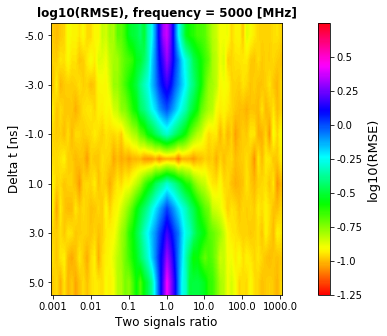

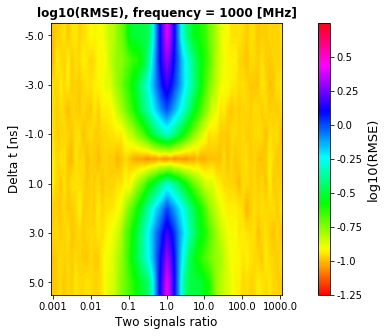

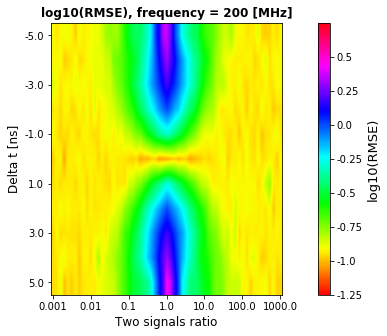

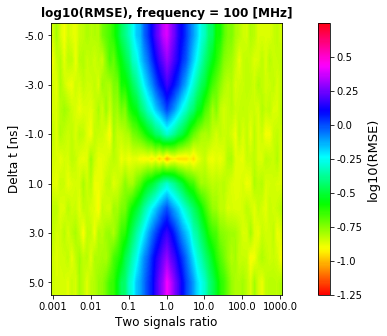

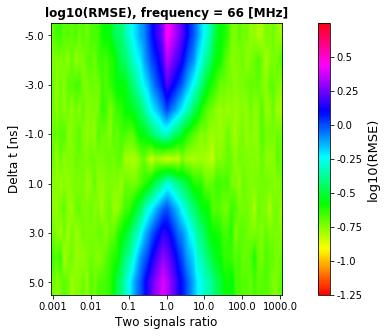

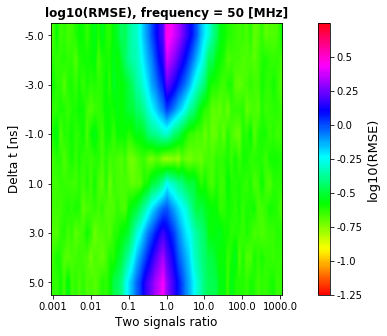

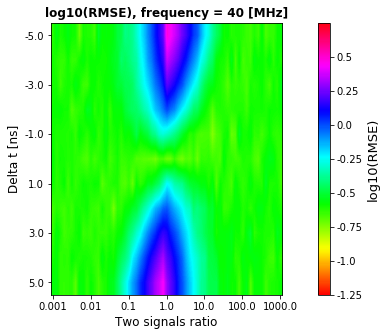

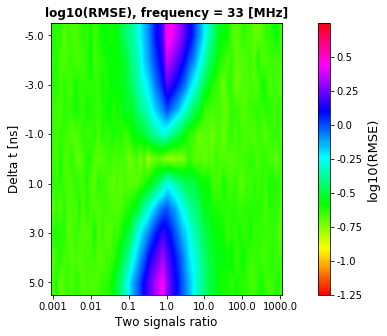

In [86]:
freq_values = [1, 5, 25, 50, 75, 100, 125, 150]

for freq in freq_values:
    plot_color_map(load_obj('scores_ref_time_freq=' + str(freq)), alpha_values, tau_values, freq=freq)

In [ ]:
X_origin, y_origin = get_data(data_path='./data/shashlik_61_pulses.txt')
X, y = prepare_data(X_origin, y_origin, tau_values, alpha_values, to_print=False, data_size=len(X_origin))

for freq in freq_values:
    scores_dict = calculate_scores(X, y, alpha_values, tau_values, data_size=500, freq=freq)
    plot_color_map(scores_dict, alpha_values, tau_values, freq=freq, cmap='hsv')
    save_obj(scores_dict, 'scores_ref_time_freq=' + str(freq))
#     plot_score_3d(scores_dict)

In [65]:
10 ** -(0.5)

0.31622776601683794

100%|██████████| 11/11 [59:59<00:00, 327.22s/it]


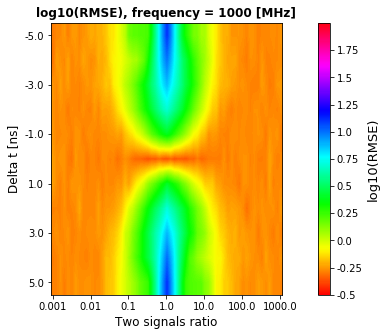

In [60]:
X_origin, y_origin = get_data(data_path='./data/shashlik_61_pulses.txt')
X, y = prepare_data(X_origin, y_origin, tau_values, alpha_values, to_print=False, data_size=len(X_origin))

freq = 5
scores_dict = calculate_scores(X, y, alpha_values, tau_values, data_size=500, freq=freq)
plot_color_map(scores_dict, alpha_values, tau_values, freq=freq, cmap='hsv')
save_obj(scores_dict, 'scores_ref_time_freq=' + str(freq))
#     plot_score_3d(scores_dict)